In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

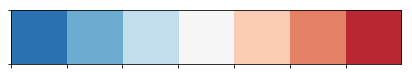

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


<p>Base com todas chuvas EXTREMAS com inicio e fim de cada chuva extrema (> 50mm em 24 horas)</p>

In [6]:
dfhr = pd.read_csv('../data/extreme_prcp_evolution.csv')
print len(dfhr)

31710


<p>Subconjunto da base principal considerando o inicio e fim das chuvas extremas (> 50mm em 24 horas)</p>

In [7]:
dfext = pd.read_csv('../data/sudeste_extreme_prcp.csv', index_col=0)
print len(dfext)

761040


# Pré-processamento

In [11]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

<h3>Limpeza dos dados</h3>

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [21]:
dfextcont.dropna(inplace=False).head(5)

,prcp,stp,smax,smin,gbrd,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust,peid
3153,0.8,986.0,986.0,985.3,5.025,22.8,22.1,22.8,22.1,22.5,21.7,96.0,96.0,95.0,0.2,156.0,1.0,4.0
3154,17.0,987.1,987.1,986.0,57.139,22.6,21.9,23.0,22.2,22.5,21.8,96.0,96.0,94.0,1.6,150.0,3.5,4.0
3155,21.0,987.4,987.5,987.1,516.903,23.1,22.2,23.3,22.7,21.9,21.3,95.0,97.0,95.0,0.3,25.0,4.6,4.0
3153,0.8,986.0,986.0,985.3,5.025,22.8,22.1,22.8,22.1,22.5,21.7,96.0,96.0,95.0,0.2,156.0,1.0,5.0
3154,17.0,987.1,987.1,986.0,57.139,22.6,21.9,23.0,22.2,22.5,21.8,96.0,96.0,94.0,1.6,150.0,3.5,5.0


In [22]:
dfextcont = dfextcont.apply(pd.to_numeric, errors='coerce')  

In [23]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761040 entries, 2881 to 9774300
Data columns (total 18 columns):
prcp    498497 non-null float64
stp     761040 non-null float64
smax    761040 non-null float64
smin    761040 non-null float64
gbrd    442663 non-null float64
temp    761040 non-null float64
tmax    761039 non-null float64
tmin    761040 non-null float64
dewp    761031 non-null float64
dmax    761040 non-null float64
dmin    761040 non-null float64
hmdy    761040 non-null float64
hmax    761040 non-null float64
hmin    761040 non-null float64
wdsp    699166 non-null float64
wdct    761040 non-null float64
gust    743830 non-null float64
peid    761040 non-null float64
dtypes: float64(18)
memory usage: 110.3 MB


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [24]:
dfextcont = dfextcont.drop('gbrd', 1)
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)
dfext = dfext.drop('gbrd',1)

In [25]:
dfextcont.describe()

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust,peid
count,498497.000000,761040.000000,761040.000000,761040.000000,761040.000000,761039.000000,761040.000000,761031.000000,761040.000000,761040.000000,761040.000000,761040.000000,761040.000000,699166.000000,761040.000000,743830.000000,761040.000000
mean,4.595885,932.860858,932.927508,932.356014,20.628916,18.654730,21.034582,19.009259,20.278253,18.332398,89.203758,90.647873,87.484752,2.098389,157.019025,5.205312,15855.500000
std,6.947355,108.631918,109.503818,109.447430,3.554264,3.726424,3.710206,3.786107,3.402126,3.703478,14.720075,13.998810,15.565180,1.698764,112.041420,3.201183,9153.894528
min,0.000000,0.000000,0.000000,0.000000,0.000000,-9.900000,0.000000,-9.900000,0.000000,-10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.600000,907.800000,908.000000,907.500000,18.700000,17.600000,19.000000,17.900000,18.500000,17.300000,89.000000,91.000000,86.000000,0.900000,61.000000,3.000000,7928.000000
50%,2.200000,939.800000,940.100000,939.500000,20.700000,19.200000,21.100000,19.600000,20.400000,18.900000,94.000000,94.000000,93.000000,1.700000,131.000000,4.600000,15855.500000
75%,5.400000,981.100000,981.300000,980.800000,22.600000,20.800000,23.000000,21.100000,22.200000,20.400000,96.000000,96.000000,96.000000,2.800000,256.000000,6.800000,23783.000000
max,100.000000,1039.000000,1040.000000,1033.600000,37.800000,33.600000,40.900000,37.500000,36.800000,32.800000,100.000000,100.000000,100.000000,16.300000,360.000000,46.000000,31710.000000


<p>Verificando os MINIMOS, MAXIMOS, MEDIAS... A precipitação 0mm indica que não houve chuva, mas pressão 0 e humidade 0 indica que a estação falhou e são dados inválidos. Desta forma estes registro devem ser excluídos.</p>

In [26]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761040 entries, 2881 to 9774300
Data columns (total 17 columns):
prcp    498497 non-null float64
stp     761040 non-null float64
smax    761040 non-null float64
smin    761040 non-null float64
temp    761040 non-null float64
tmax    761039 non-null float64
tmin    761040 non-null float64
dewp    761031 non-null float64
dmax    761040 non-null float64
dmin    761040 non-null float64
hmdy    761040 non-null float64
hmax    761040 non-null float64
hmin    761040 non-null float64
wdsp    699166 non-null float64
wdct    761040 non-null float64
gust    743830 non-null float64
peid    761040 non-null float64
dtypes: float64(17)
memory usage: 104.5 MB


<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [27]:
CAN_BE_NULL = ['wdsp','prcp','gust','dewp']

In [28]:
for v in CAN_BE_NULL:
    dfextcont[v] = dfextcont[v].fillna(0.0)
    df[v] = df[v].fillna(0.0)
    dfext[v] = dfext[v].fillna(0.0)
    dfcont[v] = dfcont[v].fillna(0.0)  

<p>Excluindo o identificador de chuva extrema</p>

In [29]:
#dfext = dfext.drop('peid',1)
#dfextcont = dfextcont.drop('peid',1)

In [30]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761040 entries, 2881 to 9774300
Data columns (total 17 columns):
prcp    761040 non-null float64
stp     761040 non-null float64
smax    761040 non-null float64
smin    761040 non-null float64
temp    761040 non-null float64
tmax    761039 non-null float64
tmin    761040 non-null float64
dewp    761040 non-null float64
dmax    761040 non-null float64
dmin    761040 non-null float64
hmdy    761040 non-null float64
hmax    761040 non-null float64
hmin    761040 non-null float64
wdsp    761040 non-null float64
wdct    761040 non-null float64
gust    761040 non-null float64
peid    761040 non-null float64
dtypes: float64(17)
memory usage: 104.5 MB


<p>Para as variáveis ento Vento Velocidade (m/s), Vento, Direção(graus) e Vento, Rajada Maxima (m/s) os valores nulos foram inputados pela média. </p>

In [31]:
MEAN = ['tmax','dmin','temp','tmin','dmax','dmin','hmin','hmax']

In [32]:
for v in MEAN:
    df[v] = df[v].fillna(value=df[v].median())
    dfext[v] = dfext[v].fillna(value=dfext[v].median())
    dfcont[v] = dfcont[v].fillna(value=dfcont[v].median())
    dfextcont[v] =  dfextcont[v].fillna(value=dfextcont[v].median())

<h2>Mineiração dos dados</h2>

<h3>Preparando a base</h3>

In [145]:
dfm.index = pd.to_datetime(dfm.mdct)
CLEAN = ['wsnm','inme','city','prov','mdct','date']
for v in CLEAN:
    dfm = dfm.drop(v,1)
dfm.head(5)        

,wsid,elvt,lat,lon,yr,mo,da,hr,prcp,stp,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
mdct,,,,,,,,,,,,,,,,,,,,,
2007-11-06 00:00:00,178,237.0,-6.835777,-38.311583,2007,11,6,0,0.0,982.5,...,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
2007-11-06 01:00:00,178,237.0,-6.835777,-38.311583,2007,11,6,1,0.0,983.2,...,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
2007-11-06 02:00:00,178,237.0,-6.835777,-38.311583,2007,11,6,2,0.0,983.5,...,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
2007-11-06 03:00:00,178,237.0,-6.835777,-38.311583,2007,11,6,3,0.0,983.7,...,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
2007-11-06 04:00:00,178,237.0,-6.835777,-38.311583,2007,11,6,4,0.0,983.7,...,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


In [146]:
dfm.describe().T

,count,mean,std,min,25%,50%,75%,max
wsid,9779168.0,359.253059,39.016300,178.000000,328.000000,358.000000,394.000000,423.0
elvt,9779168.0,594.092256,398.037895,0.000000,283.000000,573.000000,875.000000,1758.0
lat,9779168.0,-20.230815,3.172643,-24.962819,-22.395799,-20.750412,-18.917072,0.0
lon,9779168.0,-44.645904,4.882117,-56.677323,-47.434102,-44.453785,-42.435750,0.0
yr,9779168.0,2011.164228,3.207774,2000.000000,2009.000000,2011.000000,2014.000000,2016.0
mo,9779168.0,6.521960,3.425538,1.000000,4.000000,7.000000,9.000000,12.0
da,9779168.0,15.754651,8.802154,1.000000,8.000000,16.000000,23.000000,31.0
hr,9779168.0,11.500002,6.922190,0.000000,5.000000,12.000000,18.000000,23.0
prcp,9779168.0,0.134858,1.156940,0.000000,0.000000,0.000000,0.000000,100.0
stp,9779168.0,880.429177,248.264986,0.000000,911.300000,944.200000,973.100000,1050.0


<h3>Derivando novas variáveis</h3>

<p>O objetivo é derivar cada variável climática contínua em uma nova variável t-1, t-2, t-3... t-n, onde n é o numeros de horas antes do momento t.</p>

In [147]:
dfm = dfm[(dfm.wsid ==329)]
len(dfm)

87456

In [148]:
def derive_nth_hour_feature(df, feature, N):  
    rows = df.shape[0]
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]
    col_name = "{}_{}".format(feature, N)
    df[col_name] = np.nan
    df.loc[:][col_name] = nth_prior_measurements

In [149]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

for feature in dfm.columns:
    if feature not in NON_DER:
        for h in range(1,6):
            derive_nth_hour_feature(dfm, feature, h) 

In [150]:
dfm

,wsid,elvt,lat,lon,yr,mo,da,hr,prcp,stp,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
mdct,,,,,,,,,,,,,,,,,,,,,
2006-10-10 00:00:00,329,854.0,-19.883945,-43.969397,2006,10,10,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-10-10 01:00:00,329,854.0,-19.883945,-43.969397,2006,10,10,1,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2006-10-10 02:00:00,329,854.0,-19.883945,-43.969397,2006,10,10,2,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2006-10-10 03:00:00,329,854.0,-19.883945,-43.969397,2006,10,10,3,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN
2006-10-10 04:00:00,329,854.0,-19.883945,-43.969397,2006,10,10,4,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2006-10-10 05:00:00,329,854.0,-19.883945,-43.969397,2006,10,10,5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 06:00:00,329,854.0,-19.883945,-43.969397,2006,10,10,6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 07:00:00,329,854.0,-19.883945,-43.969397,2006,10,10,7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-10-10 08:00:00,329,854.0,-19.883945,-43.969397,2006,10,10,8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<p>Removendo variaveis que nâo pode ir para a rede neural</p>

In [163]:
dfm = dfm.reset_index(drop=True)

In [153]:
REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
#REMOVE = ['mdct']

for v in REMOVE:
    dfm = dfm.drop(v,1)

In [164]:
dfm.columns

Index([u'elvt', u'lat', u'lon', u'prcp', u'stp', u'smax', u'smin', u'temp',
       u'tmax', u'tmin', u'dewp', u'dmax', u'dmin', u'hmdy', u'hmax', u'hmin',
       u'wdsp', u'wdct', u'gust', u'prcp_1', u'prcp_2', u'prcp_3', u'prcp_4',
       u'prcp_5', u'stp_1', u'stp_2', u'stp_3', u'stp_4', u'stp_5', u'smax_1',
       u'smax_2', u'smax_3', u'smax_4', u'smax_5', u'smin_1', u'smin_2',
       u'smin_3', u'smin_4', u'smin_5', u'temp_1', u'temp_2', u'temp_3',
       u'temp_4', u'temp_5', u'tmax_1', u'tmax_2', u'tmax_3', u'tmax_4',
       u'tmax_5', u'tmin_1', u'tmin_2', u'tmin_3', u'tmin_4', u'tmin_5',
       u'dewp_1', u'dewp_2', u'dewp_3', u'dewp_4', u'dewp_5', u'dmax_1',
       u'dmax_2', u'dmax_3', u'dmax_4', u'dmax_5', u'dmin_1', u'dmin_2',
       u'dmin_3', u'dmin_4', u'dmin_5', u'hmdy_1', u'hmdy_2', u'hmdy_3',
       u'hmdy_4', u'hmdy_5', u'hmax_1', u'hmax_2', u'hmax_3', u'hmax_4',
       u'hmax_5', u'hmin_1', u'hmin_2', u'hmin_3', u'hmin_4', u'hmin_5',
       u'wdsp_1', u'wdsp_2', u'

In [165]:
len(dfm)

87451

In [166]:
dfm = dfm.dropna()  

In [167]:
len(dfm)

87451

<h3>Mineração dos dados</h3>

In [168]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split  

In [169]:
target = 'prcp'

In [170]:
X = dfm[[col for col in dfm.columns if col != target]]

In [171]:
y = dfm['prcp']

In [172]:
X.head(5)

,elvt,lat,lon,stp,smax,smin,temp,tmax,tmin,dewp,...,wdct_1,wdct_2,wdct_3,wdct_4,wdct_5,gust_1,gust_2,gust_3,gust_4,gust_5
0,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,854.0,-19.883945,-43.969397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<p>Separando o conjunto de treinamento e validação</p>

In [173]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3) 

<p>Separando o conjunto de testes (metade dos 30% separados para validação)</p>

In [174]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [175]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   61215, Training features   98
Validation instances 13118, Validation features 98
Testing instances    13118, Testing features    98


In [193]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
activation_fn = tf.sigmoid
batch_size = 400

In [194]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns] 

In [196]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,  
                                      hidden_units=[st_units],
                                      activation_fn=activation_fn,
                                      model_dir='tf_wx_model1-2')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe3ea7e10d0>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'tf_wx_model1-2', '_save_summary_steps': 100}


In [197]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):  
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [198]:
evaluations = []  
STEPS = 400  
for i in range(10):  
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tf_wx_model1-2/model.ckpt.
INFO:tensorflow:loss = 1109.2386, step = 1
INFO:tensorflow:global_step/sec: 29.5418
INFO:tensorflow:loss = 193.93428, step = 101 (3.387 sec)
INFO:tensorflow:global_step/sec: 30.6259
INFO:tensorflow:loss = 530.57404, step = 201 (3.265 sec)
INFO:tensorflow:global_step/sec: 30.8699
INFO:tensorflow:loss = 1248.6173, step = 301 (3.239 sec)
INFO:tensorflow:Saving checkpoints for 400 into tf_wx_model1-2/model.ckpt.
INFO:tensorflow:Loss for final step: 755.73865.
INFO:tensorflow:Starting evaluation at 2018-02-15-01:53:34
INFO:tensorflow:Restoring parameters from tf_wx_model1-2/model.ckpt-400
INFO:tensorflow:Finished evaluation at 2018-02-15-01:53:35
INFO:tensorflow:Saving dict for global step 400: average_loss = 3.0619195, global_step = 400, loss = 1217.1593
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from tf_wx_model1-2/model.ckpt-400
INFO:t

KeyboardInterrupt: 

In [191]:
len(evaluations[0])

3

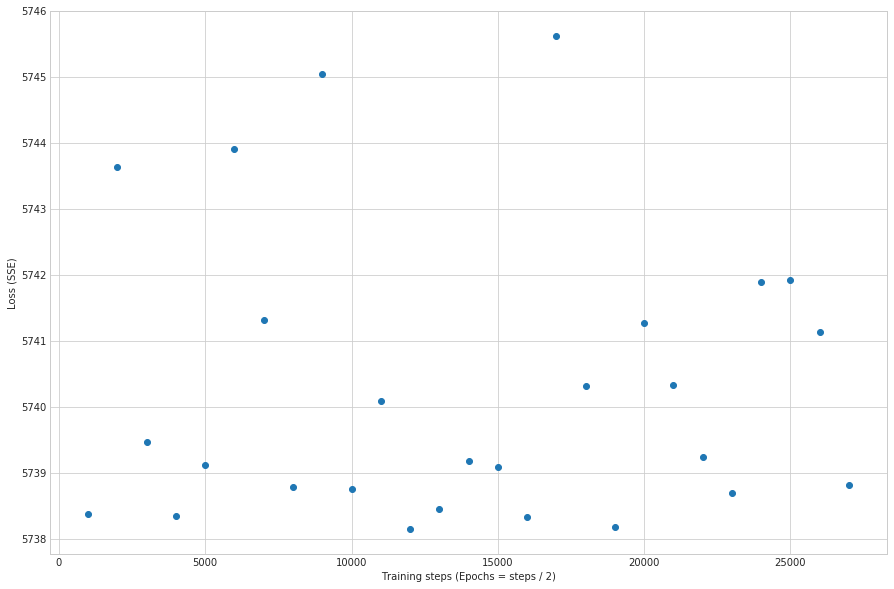

In [192]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps (Epochs = steps / 2)')  
plt.ylabel('Loss (SSE)')  
plt.show()  